In [1]:
# Install necessary packages
%pip install nltk pandas matplotlib seaborn numpy scikit-learn joblib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
import re
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import joblib  # For saving the model
from sklearn.model_selection import GridSearchCV

nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
final_data = pd.read_csv('/workspaces/IST707.Pothole-Prediction-SYR/data/processed/final_data.csv')

### Initial modeling with less data (checkpoint 2)

In [5]:
df = pd.read_csv('/workspaces/IST707.Pothole-Prediction-SYR/data/raw/SYRCityline_Requests_(2021-Present).csv')
weather_df = pd.read_csv('/workspaces/IST707.Pothole-Prediction-SYR/data/raw/40_Year_Temperature_Dataset_SU-2.csv')

In [6]:
df['Created_at_local'] = pd.to_datetime(df['Created_at_local'])
df['Description'] = df['Description'].astype(str)
potholes_df = df[df['Category'] == 'Potholes']

sia = SentimentIntensityAnalyzer()

def sentiment_score(description):
    # Tokenize the description
    tokens = word_tokenize(description)
    
    # Join the tokens back into a string (optional step, depending on your approach)
    text = ' '.join(tokens)
    
    # Calculate sentiment score
    score = sia.polarity_scores(text)['compound']
    
    # Return the compound sentiment score
    return score

potholes_df['SentimentScore'] = potholes_df['Description'].apply(sentiment_score)

def categorize_severity(score):
    if score <= -0.5:
        return 'high'
    elif score <= 0:
        return 'medium'
    else:
        return 'low'

potholes_df['SeverityLevel'] = potholes_df['SentimentScore'].apply(categorize_severity)


potholes_agg = potholes_df.groupby(potholes_df['Created_at_local'].dt.date).agg({
    'SentimentScore': 'mean',  # Average sentiment score per day
    'SeverityLevel': lambda x: x.mode()[0],  # Most common severity level per day
    'Description': 'count'  # Count the number of reports per day
}).rename(columns={'Description': 'Potholes_Count'}).reset_index().rename(columns={'Created_at_local': 'Date'})
potholes_agg['Date'] = pd.to_datetime(potholes_agg['Date'])

/tmp/ipykernel_20309/405860385.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created_at_local'] = pd.to_datetime(df['Created_at_local'])
/tmp/ipykernel_20309/405860385.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potholes_df['SentimentScore'] = potholes_df['Description'].apply(sentiment_score)
/tmp/ipykernel_20309/405860385.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [7]:
# Convert 'Year', 'Month', and 'Day' columns to a single datetime column
weather_df['Date'] = pd.to_datetime(weather_df[['Year', 'Month', 'Day']])
weather_df = weather_df[weather_df['Year'] >= 2021]
weather_df = weather_df.drop(['Year', 'Month', 'Day'], axis=1)

In [8]:
merged_df = pd.merge(weather_df, potholes_agg, on='Date', how='left')

merged_df = merged_df.fillna({
    'SentimentScore': 0,
    'Potholes_Count': 0,
    'SeverityLevel': 'unknown'
})

Text(0.5, 1.05, "Numerical features correlation (Pearson's)")

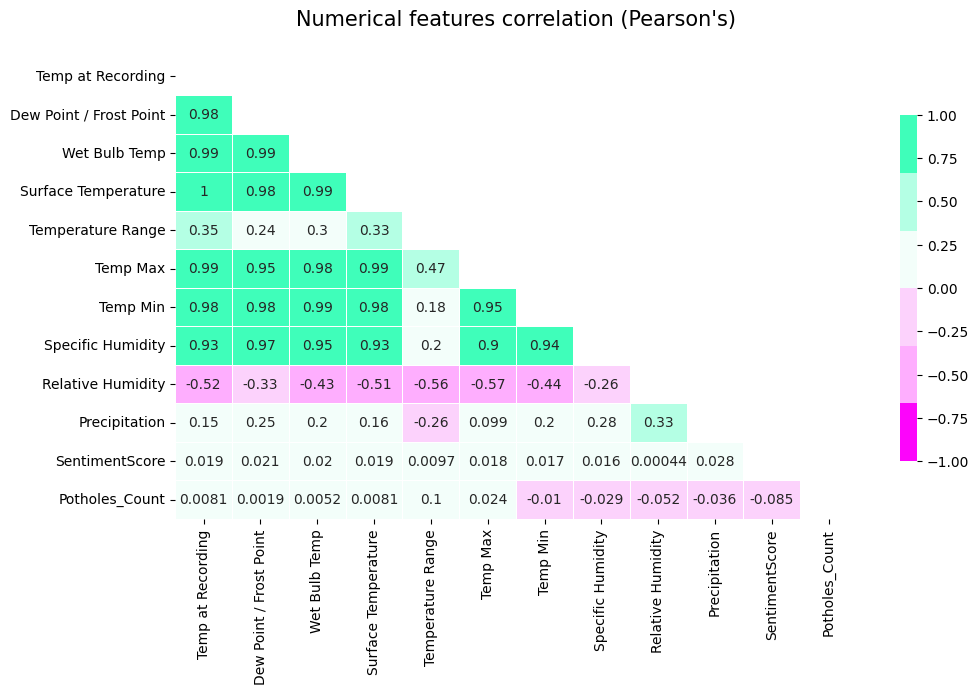

In [9]:
# numerical fearures
num_feats = ['Temp at Recording', 'Dew Point / Frost Point', 'Wet Bulb Temp', 'Surface Temperature', 'Temperature Range', 'Temp Max', 'Temp Min', 'Specific Humidity', 'Relative Humidity', 'Precipitation', 'SentimentScore', 'Potholes_Count']
# categorical 
cat_feats = ['SeverityLevel']

mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

df_ = merged_df[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 6), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=15, y= 1.05)

In [10]:
# split the data

seed = 42
test_size = 0.2

df_ = merged_df.copy()
y = df_["Potholes_Count"]
X = df_.drop("Potholes_Count", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [11]:
# define numeric and categorical features

# numerical fearures
numeric_features = ['Temp at Recording', 'Dew Point / Frost Point', 'Wet Bulb Temp', 'Surface Temperature', 'Temperature Range', 'Temp Max', 'Temp Min', 'Specific Humidity', 'Relative Humidity', 'Precipitation', 'SentimentScore']
# caterorical 
categorical_features = ['SeverityLevel', 'Date']

In [12]:
# preprocessing 

# define the preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # impute missing values with mean
    ('scaler', StandardScaler()) # scale
])

# define the preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values te most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # encoding
])

# define the transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [13]:
# Initialize the Linear Regression model
lr = LinearRegression()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Initialize an empty DataFrame to store MSE values
mse_results = pd.DataFrame(columns=['Model', 'MSE'])
new_data = pd.DataFrame({'Model': ['Less data + lr'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

Mean Squared Error: 5.9122068510423


/tmp/ipykernel_20309/4080929897.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mse_results = pd.concat([mse_results, new_data], ignore_index=True)


### Final modeling with experiments (chekpoint 3)

In [14]:
# Set your seed and test size
seed = 42
test_size = 0.2 
validation_size = 0.25  # from the remaining 80%, let's use 25% of it, i.e., 20% of the original, for validation

# Copy the DataFrame
df_ = final_data.copy()

# Separate the target variable ('Potholes_Count') from the features
y = df_["Potholes_Count"]
X = df_.drop("Potholes_Count", axis=1)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size + validation_size, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + validation_size), random_state=seed)


1. Baseline - model with all features and Linear Regression model

In [15]:
# define numeric and categorical features

# numerical fearures
numeric_features = ['Temp at Recording', 
                    'Dew Point / Frost Point', 
                    'Wet Bulb Temp', 
                    'Surface Temperature', 
                    'Temperature Range', 
                    'Temp Max', 
                    'Temp Min', 
                    'Specific Humidity', 
                    'Relative Humidity', 
                    'Precipitation', 
                    'Pavement_rating', 
                    'Miles', 
                    'Shape__Length',
                    'SentimentScore', 
                    'Rating', 
                    'Minutes_to_closed']
# caterorical 
categorical_features = ['SeverityLevel', 'Matched_Street','Date']

run the preprocessing pipelines for categorical and numerical columnns and run through a transformer

In [16]:
# preprocessing 

# define the preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # impute missing values with mean
    ('scaler', StandardScaler()) # scale
])

# define the preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values te most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # encoding
])

# define the transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

run a linear regression model 

In [17]:
# Initialize the Linear Regression model
lr = LinearRegression()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lr)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.14658292446471866


Mean Squared error is much smaller with the added data sets than with the original two sets

In [18]:
# Initialize an empty DataFrame to store MSE values
new_data = pd.DataFrame({'Model': ['All feats + lr'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

2. Drop the highly correlated features

In [19]:
# Retain one temperature feature (for example) and drop the highly correlated ones
numeric_features2 = [
    'Surface Temperature',  # Chosen temperature feature
    'Temperature Range', 
    'Specific Humidity', 
    'Relative Humidity', 
    'Precipitation', 
    'Pavement_rating', 
    'Miles', 
    'Shape__Length',
    'SentimentScore', 
    'Rating', 
    'Minutes_to_closed'
]

Rerun the transformer and regression only on one of the temperature features, rather than the set that are highly correlated

In [20]:
# define the transformer
preprocessor2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features2),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', lr)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.14586064916196426


In [21]:
new_data = pd.DataFrame({'Model': ['Less feats + lr'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

3. Design some features

In [22]:
class CustomFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for these transformations
        return self

    def transform(self, X):
        # Ensure you are not modifying the original dataset
        X = X.copy()
        
        # Feature 1: Interaction between 'Surface Temperature' and 'Specific Humidity'
        X['Temp_Humidity_Interaction'] = X['Surface Temperature'] * X['Specific Humidity']
        
        # Feature 2: Log Transformation of 'Miles' to normalize the distribution
        # Adding 1 to avoid issues with log(0)
        X['Log_Miles'] = np.log1p(X['Miles'])
        
        # Feature 3: Inverse of 'Minutes_to_closed' (adding 1 to avoid division by zero)
        X['Inverse_Minutes_to_closed'] = 1 / (X['Minutes_to_closed'] + 1)
        
        return X

Rerun with the new custom features

In [23]:
# define the transformer
preprocessor = ColumnTransformer(transformers=[
    ('custom_features', CustomFeatureEngineer(), numeric_features2),
    ('num', numeric_transformer, numeric_features2),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12782866315630576


An improved mean squared error with the custom features

In [24]:
new_data = pd.DataFrame({'Model': ['Feat engineering + lr'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

4. Add binning and polnomial transformer

In [25]:
polynomial_features = ['Temperature Range']
binning_features = ['Shape__Length']

polynomial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Define a new transformer for binning
binning_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('binning', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform')),
    ('scaler', StandardScaler())
])

# Define the remaining numeric features that will undergo standard numeric transformation
standard_numeric_features = list(set(numeric_features2) - set(polynomial_features) - set(binning_features))

# Transformer for standard numeric features
standard_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# define the transformer
preprocessor = ColumnTransformer(transformers=[
    ('custom_features', CustomFeatureEngineer(), standard_numeric_features),
    ('poly', polynomial_transformer, polynomial_features),
    ('bin', binning_transformer, binning_features),
    ('num', standard_numeric_transformer, standard_numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.11009987486240906


once again, a slightly improved MSE with binning

In [26]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + lr'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

5. Prevent regularization - Ridge

In [27]:
# Ridge regression with near-zero regularization
ridge = Ridge(alpha=1e-10)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ridge)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.13660381600544944


Ridge regression with minimal regularization saw a worse MSE

In [28]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + ridge'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

6. Prevent regularization - Lasso

In [29]:
# Lasso regression with a specific alpha
lasso = Lasso(alpha=0.01)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lasso)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12509829442918527


Lasso regression saw a better MSE than the Ridge, but still worse than previous experiments

In [30]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + lasso'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

7. Prevent regularization - ElasticNet

In [31]:
# ElasticNet regression with specific alpha and l1_ratio
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', elasticnet)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12043281404147259


Elasticnet regresssion so far has the best MSE

In [32]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + elasticnet'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

We tried a different L1 ratio to see if we could improve the MSE

In [33]:
# ElasticNet regression with specific alpha and l1_ratio
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.7)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', elasticnet)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12233713255552044


8. New model - Random Forest

In [34]:
# ElasticNet regression with specific n_estimators
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('RandomForest', rf_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.13370699088145896


In [35]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + RF'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

We tried a different number of n_estimators, but didn't see an imporvement

In [36]:
# ElasticNet regression with specific n_estimators
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('RandomForest', rf_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1374772036474164


We then tried adding in max depth and saw a minor improvement

In [37]:
# ElasticNet regression with specific alpha and l1_ratio
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth= 20, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('RandomForest', rf_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1336955288897454


We reduced the max_depth down even more, and saw the best iteration so far of the randomforest regressors

In [38]:
# ElasticNet regression with specific alpha and l1_ratio
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth= 12, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('RandomForest', rf_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.13170630541163125


9. New model - Gradient Boosting 

In [39]:
# ElasticNet regression with specific alpha and l1_ratio
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('GradientBoosting', gb_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.12904531932761754


In [40]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + GB'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

Working with the number of n_estimators, a decrease in the quantity was not an improvement

In [41]:
# ElasticNet regression with specific alpha and l1_ratio
gb_regressor = GradientBoostingRegressor(n_estimators=10, random_state=seed)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('GradientBoosting', gb_regressor)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.167227905798311


10. New model - Stacking regression

In [42]:
# Define different regressors
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=seed)
svm_regressor = SVR(kernel='rbf')

# Define a stacking regressor
estimators = [
    ('rf', rf_regressor),
    ('gb', gb_regressor),
    ('svm', svm_regressor)
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=rf_regressor)

# Update the pipeline with the stacking regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)  # Using stacking of models
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.13606808510638302


This was one of our worst models yet

In [43]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + stacking'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

11. New model - Voting regression

In [44]:
# Combine multiple regressors
voting_regressor = VotingRegressor(
    estimators=[
        ('elastic_net', ElasticNet(alpha=0.01, l1_ratio=0.5)),
        ('gradient_boosting', GradientBoostingRegressor(n_estimators=100)),
        ('random_forest', RandomForestRegressor(n_estimators=100))
    ]
)

# Update pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', voting_regressor)
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("MSE with Voting Regressor:", mse)

MSE with Voting Regressor: 0.1257755163694852


In [45]:
new_data = pd.DataFrame({'Model': ['Bining, polynomial transformer + voting'], 'MSE': [mse]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

12. Choose the best model and tune with grid search

In [46]:
# ElasticNet regression with specific alpha and l1_ratio
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', elasticnet)
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict potholes count on the testing data
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Set up the parameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.05, 0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid_search to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

# Best model
best_model = grid_search.best_estimator_

# Predict and evaluate using the best configuration
y_test_pred = best_model.predict(X_val)
test_mse1 = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {test_mse1}")

Mean Squared Error: 0.12043281404147259


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.945337341228349, tolerance: 0.022874956822107082
  model = cd_fast.sparse_enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.457192811256652, tolerance: 0.023052158894645937
  model = cd_fast.sparse_enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.982457133327149, tolerance: 0.021874611398963725
  model = cd_fast.sparse_enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-package

Best parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}
Best score (MSE): 0.07927209808119069
Validation MSE: 0.12043281404147259


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.78259409315129, tolerance: 0.027497790055248612
  model = cd_fast.sparse_enet_coordinate_descent(


using gridsearch, we got the best MSE so far with the regressor alpha of 0.01, and an l1 ration of 0.1

In [47]:
new_data = pd.DataFrame({'Model': ['best_model on val data'], 'MSE': [test_mse1]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

We then used the best model on the test set, and saw the best MSE yet

In [48]:
y_test_pred = best_model.predict(X_test)
test_mse2 = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse2}")

Test MSE: 0.036961961263827565


In [49]:
new_data = pd.DataFrame({'Model': ['best_model on test data'], 'MSE': [test_mse2]})
mse_results = pd.concat([mse_results, new_data], ignore_index=True)

In [50]:
model_order = mse_results['Model'].iloc[::-1].tolist()

/tmp/ipykernel_20309/589433525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


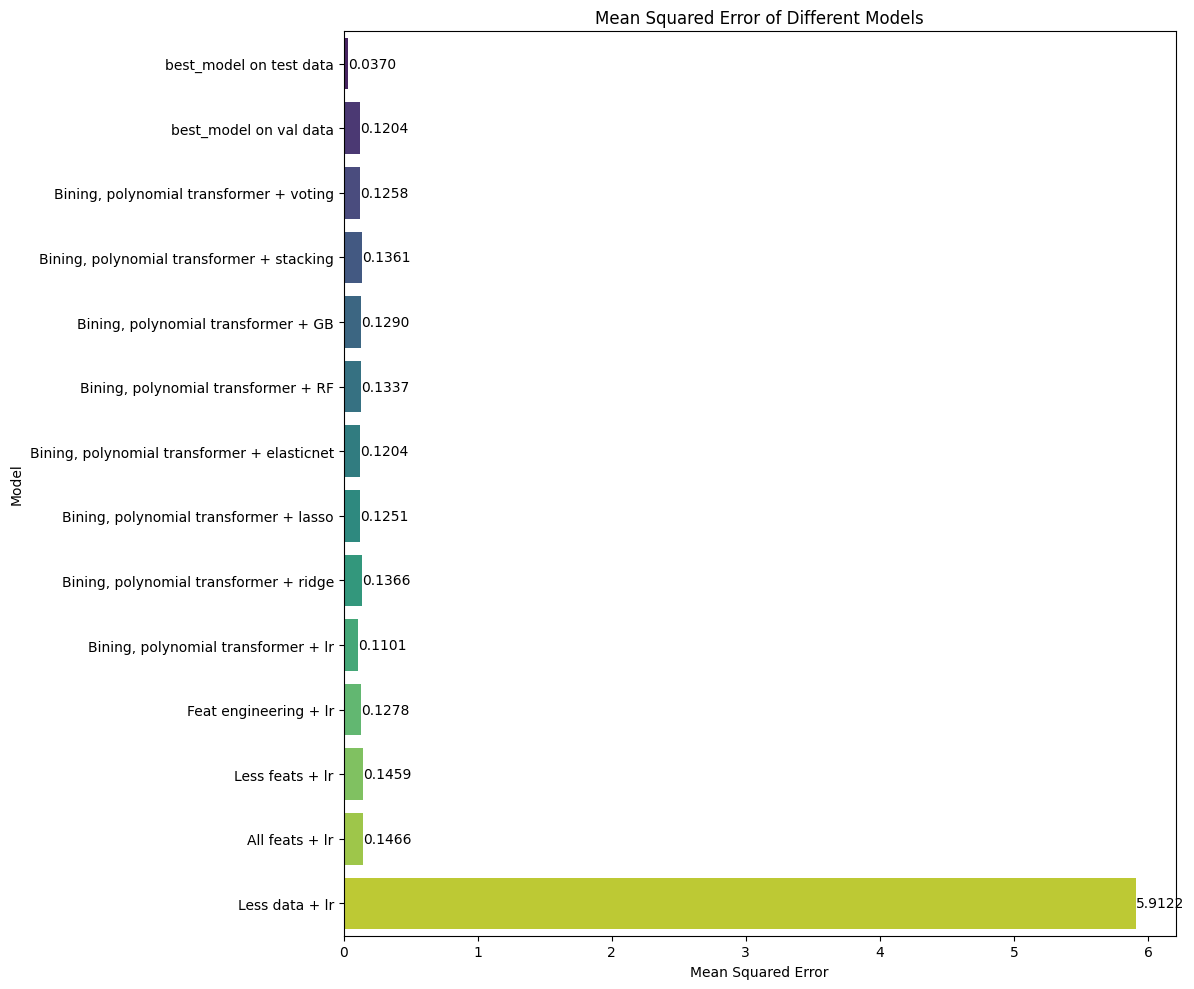

In [51]:
plt.figure(figsize=(12, 10))
barplot = sns.barplot(
    x='MSE', 
    y='Model', 
    data=mse_results,
    palette="viridis",
    orient='h',
    order=model_order  # Pass the reversed order of models
)

# Annotate the MSE values on the bars
for p in barplot.patches:
    plt.text(
        p.get_width(),  # The end of the bar
        p.get_y() + p.get_height() / 2,  # Center of the bar
        f'{p.get_width():.4f}',  # The MSE value
        va='center',  # Center vertically
        ha='left',  # Align text to the left (after the bar end)
        color='black',
        fontsize=10
    )

# Set the title and labels
plt.title('Mean Squared Error of Different Models')
plt.xlabel('Mean Squared Error')
plt.ylabel('Model')

# Show the plot
plt.tight_layout()
plt.show()

In [52]:
# Save the model to disk
joblib.dump(best_model, '/workspaces/IST707.Pothole-Prediction-SYR/models/elasticnet_model.pkl')
print("Model saved as 'elasticnet_model.pkl'")

Model saved as 'elasticnet_model.pkl'


In [53]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
results_df.to_csv('/workspaces/IST707.Pothole-Prediction-SYR/predictions/test_predictions.csv', index=False)
print("Results saved to 'test_predictions.csv'")

Results saved to 'test_predictions.csv'


## Conclusion

This notebook walks through all of the steps that our team used to optimize our machine learning project to predict the number of potholes per year in Syracuse, NY. We used many different models with generic hyperparameters set and found that the elasticnet model was the best initially. To evaluate each of the models, we calculated the mean squared error, and looked for the smallest error. In some of the better initial models, we did some minor hyperparameter tuning to experiment, but ended up using gridsearch on the elasticnet model to find the best set of parameters to run with our model, which were a regressor alpha of 0.01, and an l1 ration of 0.1 For a final evaluation, we ran the elasticnet optimized model on the test set, and got a mean squared error on the test set of 0.0339. 

This model can be utilized by Syracuse, NY officials to help plan budgets for the future number of potholes that will need to be fixed. 